# data science take home assignment
Brian Lakey  
2022-01-26

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## data ingestion and exploration

In [2]:
rental, booking = (pd.read_csv(f"..\data\{filename}.csv") for filename in [
    "outdoorsy_rental_data", "outdoorsy_booking_history"
])

In [3]:
rental.head()

,rental_id,listing_state,vehicle_type,is_motorized,vehicle_make,vehicle_model,vehicle_year,vehicle_length,cancellation_policy,sleeps,is_festival_friendly,is_tailgate_friendly,is_pet_friendly,has_toilet,has_generator,has_inside_shower,has_refrigerator,has_wifi
0,206969964720,CA,trailer,False,Airstream,Safari,2008,20 - 25,flexible,4,False,True,True,True,False,True,True,False
1,374663654160,CA,c,True,Forest River,Sunseeker,2012,30 - 35,custom,9,True,True,False,True,True,True,True,False
2,436102091040,CA,c,True,forest river,Sunseeker,2011,30 - 35,strict,8,True,True,True,True,True,True,True,False
3,494831819280,MI,b,True,Leisure Travel,Serenity,2015,25 - 30,strict,4,False,False,True,True,True,True,True,False
4,645780764400,KY,a,True,Thor Motor Coach,Miramar,2016,35 - 40,moderate,10,True,True,False,True,True,True,True,False


In [4]:
# number of rentals (listings?)
print(len(rental))

# uniquely identified by rental_id
assert len(rental) == len(pd.unique(rental["rental_id"]))

3000


In [5]:
booking.head()

,rental_id,booked_price_per_day,month_booked
0,25313374733280,$222.31,7
1,13557825481920,$146.93,11
2,18214711249680,$183.85,9
3,20892146617200,$271.92,7
4,25286903262480,$127.84,6


In [6]:
# not uniquely identified by rental_id & month_booked
print(len(booking))
print(len(np.unique(booking["rental_id"])))
print(len(booking.groupby(["rental_id", "month_booked"])))

3849
2792
3576


In [7]:
dupes = booking.groupby(
    ["rental_id", "month_booked"]
).count().sort_values(
    by="booked_price_per_day", ascending=False
)
# multiple records for single rental+month
dupes.head()

,,booked_price_per_day
rental_id,month_booked,
8888134909680,6,4
22390431864480,6,4
29123542804800,7,4
4552600485120,12,4
8348116905360,6,3


In [8]:
# in fact, there are some entirely duplicated records, not identified by rental_id, month_booked, and booked_price_per_day
mask = (booking["rental_id"]==dupes.index[0][0]) & \
       (booking["month_booked"]==dupes.index[0][1])
booking[mask]

,rental_id,booked_price_per_day,month_booked
283,8888134909680,$92.59,6
1970,8888134909680,$92.59,6
1983,8888134909680,$86.33,6
2186,8888134909680,$86.33,6


In [9]:
# making the assumption that these completed duplicated records are data sanitation issues
# dropping duplicate records
booking = booking.drop_duplicates()

In [10]:
df = pd.merge(rental, booking, on="rental_id")

## analysis and visualization

### 1. What is the average daily price per month for class c rentals?

In [11]:
# feature exploration
df["vehicle_type"].value_counts()

trailer            1285
c                  1049
camper-van          539
b                   389
a                   314
fifth-wheel          83
truck-camper         62
toy-hauler           52
folding-trailer      46
Name: vehicle_type, dtype: int64

In [12]:
# need to combine numerical and string representations
df["month_booked"].value_counts()

6            712
7            664
8            525
9            473
10           472
11           364
12           325
5            233
July          10
September      9
June           8
August         6
December       6
October        6
May            3
November       3
Name: month_booked, dtype: int64

In [13]:
# because of string values, entire column is encoded as object
month_dict = {
    "January": "1",
    "February": "2",
    "March": "3",
    "April": "4",
    "May": "5",
    "June": "6",
    "July": "7",
    "August": "8",
    "September": "9",
    "October": "10",
    "November": "11",
    "December": "12"
}
# define mapping dictionary and use .replace to update string values, recode as int
# .assign is preferred pandas column assignment API, although IMO it is not pythonic
df = df.assign(month_booked_num=df["month_booked"].replace(month_dict).astype(int))
df = df.drop_duplicates()  # in case month reassignment led to more data sanitation issues

assert df["month_booked_num"].dtype == int

In [14]:
df["month_booked_num"].value_counts()

6     720
7     674
8     531
9     482
10    478
11    367
12    331
5     236
Name: month_booked_num, dtype: int64

In [15]:
# investigating dependent variable

# uh-oh, some invalid entries in upstream data, perhaps an issue of taking averages for bookings attributed to different month
# these should really be encoded as null
df["booked_price_per_day"].sort_values().head()

2208    #DIV/0!
1983    #DIV/0!
3220    #DIV/0!
3235      $0.36
1823      $0.86
Name: booked_price_per_day, dtype: object

In [16]:
# also, all booked_prices are encoded as strings with accounting characters, need to clean and convert to float
df = df.assign(booked_price_per_day_num=df["booked_price_per_day"]
    .replace("[$,]", "", regex=True)  # remove the accounting characters
    .replace("#DIV/0!", np.nan)  # replace the div/0 with nulls (don't remove records at this stage)
    .astype(float)  # cast as float for numerical operations
)
df["booked_price_per_day_num"].sort_values() 

3235       0.36
1823       0.86
3647       1.13
3711       1.21
1822       2.57
         ...   
730     1270.65
1602    1520.93
1983        NaN
2208        NaN
3220        NaN
Name: booked_price_per_day_num, Length: 3819, dtype: float64

In [17]:
mask = df["vehicle_type"] == "c"  # only c-class RVs

# groupby and take average
# average frequently refers to mean, but can mean any aggregating function that summarizes data
# taking both mean and median (some robustness)
monthly_avg = df[mask].groupby(
    "month_booked_num", dropna=True
).agg([np.mean, np.median])["booked_price_per_day_num"]

print(monthly_avg)

                        mean   median
month_booked_num                     
5                 215.907879  193.095
6                 212.971243  199.790
7                 233.187254  218.280
8                 240.465793  231.360
9                 245.674480  236.580
10                242.999286  230.860
11                234.897476  220.810
12                242.132326  219.720


- answer to __Analysis 1__
- lower median does indicate skewed (non-normal/non-Gaussian) price distribution

<AxesSubplot:title={'center':'average monthly rental rates for class c RVs'}, xlabel='month_booked_num', ylabel='nightly rate ($)'>

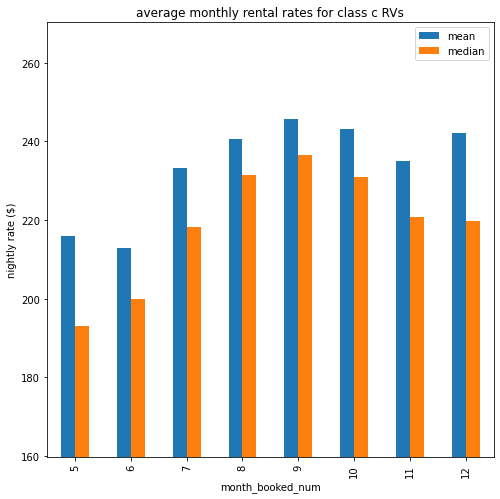

In [18]:
# non-zero lower ylim (purely for visual comparison)
ymin, ymax = map(lambda f: f(monthly_avg["mean"]), [min, max])
monthly_avg.plot.bar(
    ylim=(ymin*.75, ymax*1.1), figsize=(8, 8),
    title="average monthly rental rates for class c RVs", ylabel="nightly rate ($)"
)

### 2. For motorized vs non-motorized vehicles, plot the average daily value of a rental by year model
    a. What percent of listings fall outside of the average within 1 standard deviation?

In [19]:
# about 60% of rentals in this data set are motorized
df['is_motorized'].value_counts(normalize=True)

True     0.599895
False    0.400105
Name: is_motorized, dtype: float64

In [20]:
# doubt this RV is 2,022 years old
print(df["vehicle_year"].sort_values())

# Int64 is an integer data type that accommodates NaNs
df = df.assign(vehicle_year_num=df["vehicle_year"].replace(0, np.nan).astype("Int64"))

458        0
563     1945
822     1962
281     1965
580     1971
        ... 
3755    2022
3754    2022
3250    2022
3216    2022
3818    2022
Name: vehicle_year, Length: 3819, dtype: int64


In [21]:
# group by vehicle year model and motorized status
yearly_motor_avg = df.groupby(
    ["vehicle_year_num", "is_motorized"], dropna=True
).agg(
    [np.mean, np.median, np.std, len]  # calculate within-group statistics
)["booked_price_per_day_num"]

# len here represents "support", or number of observations per group
# many subgroups have only single exemplars and should be treated carefully
yearly_motor_avg = yearly_motor_avg.reset_index()
yearly_motor_avg.sort_index()

,vehicle_year_num,is_motorized,mean,median,std,len
0,1945,False,86.560000,86.560,NaN,1
1,1962,False,99.510000,99.510,NaN,1
2,1965,False,134.080000,134.080,NaN,1
3,1971,True,146.990000,146.990,NaN,1
4,1972,True,194.330000,194.330,NaN,1
...,...,...,...,...,...,...
84,2020,True,305.964753,266.760,171.344095,224
85,2021,False,152.122611,143.340,52.617543,452
86,2021,True,316.259792,292.985,115.017553,289
87,2022,False,150.116818,140.905,32.832014,22


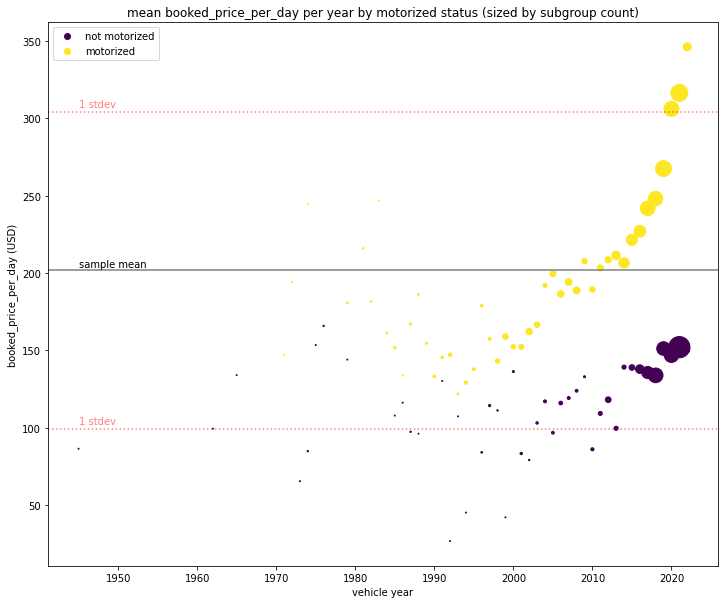

In [22]:
# scatter plot of booked_price_per_day by vehicle year and motorized status
# visualizing the number of observations per group with bubble size

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    x=yearly_motor_avg["vehicle_year_num"],
    y=yearly_motor_avg["mean"],
    c=yearly_motor_avg["is_motorized"],  # color
    s=yearly_motor_avg["len"]  # bubble size, nice visual cue to account for observation count
)
# add legend (always label your plots)
plt.legend(handles=scatter.legend_elements()[0], labels=["not motorized", "motorized"])
plt.title("mean booked_price_per_day per year by motorized status (sized by subgroup count)")
plt.ylabel("booked_price_per_day (USD)")
plt.xlabel("vehicle year")

# add horizontal lines for mean and stdev
mu, sigma = map(lambda f: f(df["booked_price_per_day_num"]), [np.mean, np.std])  # I know functional isn't pythonic, but it's so nice
plt.axhline(y=mu, color="grey", linestyle='-')
text_x = yearly_motor_avg["vehicle_year_num"].min()
plt.text(text_x, mu*1.01, "sample mean")
for s in [mu+sigma, mu-sigma]:
    plt.axhline(y=s, color="red", linestyle=':', alpha=0.5)
    plt.text(text_x, s+3, "1 stdev",c='red', alpha=0.5)
plt.show()

In [23]:
within_std = df['booked_price_per_day_num'].between(mu-sigma, mu+sigma)
print("rentals outside sample mean +- 1 stdev: {}, {:.2f}%".format(
    (~within_std).sum(), (~within_std).mean() * 100)  # opposite of within (~) is outside
)

rentals outside sample mean +- 1 stdev: 794, 20.79%


- partial answer to __Analysis 2a__ (might as well include it since I had done it anyway before clarifying)
  - 20.7% of rentals lie outside the overall sample mean +- 1 standard deviation

In [24]:
import pprint

# group by vehicle year model and motorized status
# put into dict container for key updating with new values
motor_stats = df.groupby("is_motorized", dropna=True).agg(
    [np.mean, np.std]
)["booked_price_per_day_num"].reset_index().to_dict(orient="records")

# iterate through dictionaries (each is mean and stdev for each motorized status)
# mask original data by motorized status and calculate percent outside mean +- 1 stdev
for d in motor_stats:
    mask = df["is_motorized"] == d["is_motorized"]  # this is a boolean key from the groupby
    mu, sigma = [d[key] for key in ["mean", "std"]]  # mean and std aggregations
    within_std = df[mask]['booked_price_per_day_num'].between(mu-sigma, mu+sigma)
    
    # insert new keys
    d["outside_count"] = (~within_std).sum()
    d["outside_percent"] = (~within_std).mean()
    
# pprint for formatting
pprint.pprint(motor_stats)

[{'is_motorized': False,
  'mean': 141.05715968586387,
  'outside_count': 403,
  'outside_percent': 0.2637434554973822,
  'std': 50.892852845706585},
 {'is_motorized': True,
  'mean': 242.52254370629367,
  'outside_count': 453,
  'outside_percent': 0.19773024879965082,
  'std': 107.8087561259209}]


In [25]:
for d in motor_stats:
    motor_status = "    motorized" if d["is_motorized"] else "not motorized"
    print("rentals outside {} subsample mean +- 1 stdev: {}, {:.2f}%".format(
        motor_status, d["outside_count"], d["outside_percent"] * 100)
    )

rentals outside not motorized subsample mean +- 1 stdev: 403, 26.37%
rentals outside     motorized subsample mean +- 1 stdev: 453, 19.77%


- clarified answer to __Analysis 2a__
  - 26.4% of non-motorized rentals lie outside the subsampe sample mean +- 1 standard deviation
  - 19.8% of motorized rentals lie outside the subsampe sample mean +- 1 standard deviation

### 3. How does the average value of a listing change over time? Are there any patterns you can detect? How does location affect the average rate? Seasonality?

Given the nature of the booking data (that we don't have full records for each booking transaction for each RV), it's not possible to track the value of a single listing over the time that it's on the platform.  

Instead, the best way to approach this question is to assess the average value of a listing with respect to vehicle age, with an older vehicle as proxy for "longer time."

Text(0.5, 0, 'vehicle year')

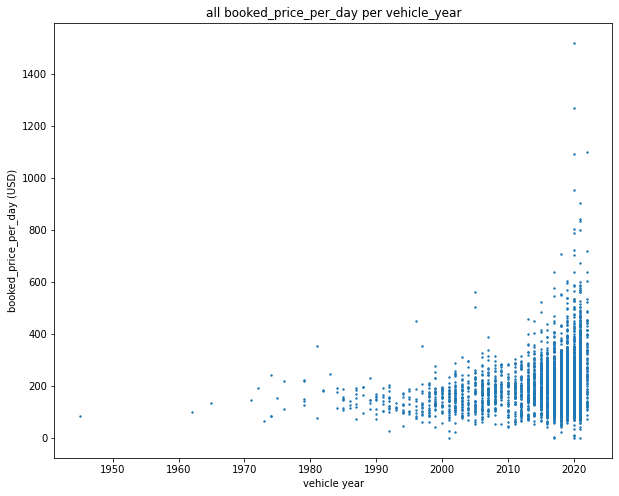

In [26]:
# scatter plot of booked_price_per_day by vehicle year and motorized status
# visualizing the number of observations per group with bubble size

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
df_scatter = df.dropna(subset=["vehicle_year_num", "booked_price_per_day_num"])
ax.scatter(
    x=df_scatter["vehicle_year_num"],
    y=df_scatter["booked_price_per_day_num"], 
    s=2
)
ax.set_title("all booked_price_per_day per vehicle_year")
ax.set_ylabel("booked_price_per_day (USD)")
ax.set_xlabel("vehicle year")

In general, as an RV gets older, the value decreases.  However, there are some anti-patterns that can be slightly observed, especially in the motorized class, where the oldest, or perhaps "most vintage" RVs, are commanding a higher price point.  This does not seem to be the case for non-motorized RVs.

In [27]:
# examining any regional/location patterns
state_gb = df.groupby(
    ["listing_state"], dropna=True
).agg(
    [np.mean, len]  # calculate within-group statistics
)["booked_price_per_day_num"]

state_gb = state_gb.reset_index().sort_values(by="mean", ascending=False)
display(state_gb.head(8))
display(state_gb.tail(8))

# one dude in North Dakota swanked out
# what I'm guessing is New South Wales (AUS) has a bit of a beater

# overall, no obvious pattern stands out
# however, some of these locations have very few observations, and should be treated carefully
# especially the regions with the highest and lowest average only have single examples

,listing_state,mean,len
30,ND,293.250000,1
33,NJ,291.855577,52
45,SC,264.651154,52
54,WV,249.432000,10
8,CT,237.721250,16
40,ON,228.649375,32
19,KY,223.033824,35
42,PA,221.417455,55


,listing_state,mean,len
13,HI,174.329766,128
18,KS,173.720000,10
20,LA,172.019500,20
34,NM,160.334500,20
53,WI,156.738444,45
44,RI,154.096000,5
3,AR,152.918667,15
35,NSW,65.620000,1


In [39]:
# not too difficult to plot hues against pre-defined US maps (this does leave out non-US states)
# since states do have geographic relationships, perhaps non-obvious patterns will emerge

#https://plotly.com/python/choropleth-maps/#using-builtin-country-and-state-geometries
import plotly.express as px

fig = px.choropleth(
    locations=state_gb['listing_state'],
    locationmode="USA-states",
    color=state_gb['mean'],
    scope="usa",
    color_continuous_scale=px.colors.sequential.Viridis,
    title="US states, colored by mean booked_price_per_day"
)
# fig.show()
# ended up screenshotting and saving as png, since it is an interactive html that doesn't render non-locally

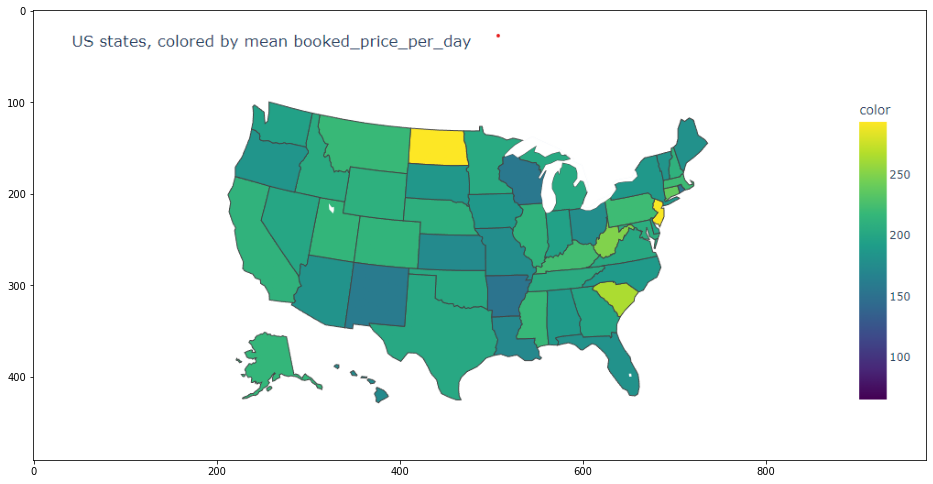

In [38]:
import matplotlib.image as mpimg

plt.figure(figsize=(16, 14))
img = mpimg.imread('../images/us_states.png')
imgplot = plt.imshow(img)
plt.show()
# unfortunately, can't really draw any conclusions


<AxesSubplot:title={'center':'total booked price per month, may-december'}, xlabel='month_booked_num', ylabel='sum of booked_price_per_day, USD'>

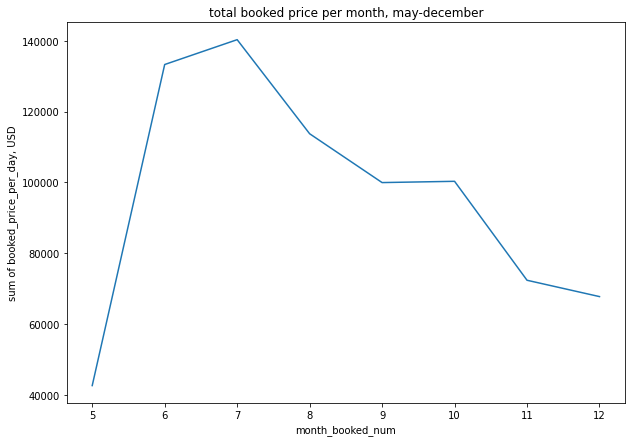

In [29]:
# investigating seasonality, or at least monthly booking patterns
df.groupby("month_booked_num").sum()["booked_price_per_day_num"].plot(
    figsize=(10, 7), title="total booked price per month, may-december", ylabel="sum of booked_price_per_day, USD"
)

It does seem, in general, that the highest travel months are in the summer (June, July, and August), which is consistent with better weather in the northern hemisphere for outdoor camping.  May is surprisingly low (especially relative to December), but this may be a result of the data being cuttoff and not including all May reservations.

In general, this conclusion is making the assumption that `booking_month` is the date of travel, __not__ the date the reservation was made.  For travel platforms, the interaction between lead time (time between reservation and date of travel) is very significant, which is impossible to tell from this data.  Seasonality in general should be thought of through this lens, which is when the reservations are made, and can interact significantly with market.

## modeling

### 1. Which features in the dataset have the most impact on the average daily value of a rental?  
    a. If you see any missing value, use the approach that you think is the best fit for this use case and explain why.  

In [30]:
# examining null counts
pd.isnull(df).sum()

rental_id                     0
listing_state                19
vehicle_type                  0
is_motorized                  0
vehicle_make                 34
vehicle_model                23
vehicle_year                  0
vehicle_length                0
cancellation_policy         113
sleeps                        0
is_festival_friendly          0
is_tailgate_friendly          0
is_pet_friendly               0
has_toilet                    0
has_generator                 0
has_inside_shower             0
has_refrigerator              0
has_wifi                      0
booked_price_per_day          0
month_booked                  0
month_booked_num              0
booked_price_per_day_num      3
vehicle_year_num              1
dtype: int64

In [31]:
# drop record when both vehicle make and model are null
mask = [pd.notnull(df[col]) for col in ["vehicle_make", "vehicle_model"]]
df_model = df[(mask[0]) | (mask[1])]  # inclusive or

In [32]:
# can we determine the make or model manually?
# with only 11 records where either the make or model is null, manual is feasible
make_mod_cols = ["vehicle_make", "vehicle_model"]
mask = [pd.isnull(df_model[col]) for col in make_mod_cols]  # two boolean masks, one for each of vehicle_make and vehicle_model
df_model[(mask[0]) | (mask[1])]  # inclusive or

,rental_id,listing_state,vehicle_type,is_motorized,vehicle_make,vehicle_model,vehicle_year,vehicle_length,cancellation_policy,sleeps,...,has_toilet,has_generator,has_inside_shower,has_refrigerator,has_wifi,booked_price_per_day,month_booked,month_booked_num,booked_price_per_day_num,vehicle_year_num
2667,27851557852080,GA,trailer,False,NaN,Bullet 330 BHS,2021,35 - 40,moderate,10,...,True,True,True,True,False,$183.99,7,7,183.99,2021
2668,27851557852080,GA,trailer,False,NaN,Bullet 330 BHS,2021,35 - 40,moderate,10,...,True,True,True,True,False,$151.28,6,6,151.28,2021
2887,28624401676320,CA,c,True,NaN,Greyhawk,2021,25 - 30,moderate,8,...,True,True,True,True,False,$320.47,12,12,320.47,2021
2888,28624401676320,CA,c,True,NaN,Greyhawk,2021,25 - 30,moderate,8,...,True,True,True,True,False,$359.07,12,12,359.07,2021
2889,28624401676320,CA,c,True,NaN,Greyhawk,2021,25 - 30,moderate,8,...,True,True,True,True,False,$357.28,6,6,357.28,2021
3079,29241987246240,QC,c,True,NaN,CTV,2013,20 - 25,moderate,4,...,True,False,True,True,False,$180.14,11,11,180.14,2013
3080,29241987246240,QC,c,True,NaN,CTV,2013,20 - 25,moderate,4,...,True,False,True,True,False,$224.65,10,10,224.65,2013
3081,29241987246240,QC,c,True,NaN,CTV,2013,20 - 25,moderate,4,...,True,False,True,True,False,$459.65,6,6,459.65,2013
3512,31217128337280,CO,c,True,NaN,Chateau Citation Sprinter,2017,20 - 25,flexible,6,...,True,True,True,True,False,$287.04,8,8,287.04,2017
3513,31217128337280,CO,c,True,NaN,Chateau Citation Sprinter,2017,20 - 25,flexible,6,...,True,True,True,True,False,$246.58,10,10,246.58,2017


In [33]:
pd.options.mode.chained_assignment = None  # I know what I'm doing, promise... 

# lower case and account for minimal formatting (combines some slightly different strings)
for col in make_mod_cols:
    df_model[col] = df_model[col].str.lower().replace("[-]", " ", regex=True)

# oh lordy, there are still so many
model_set, make_set = (set(df_model[col]) for col in make_mod_cols)
print(f"number of unique models: {len(model_set)}")
print(f"number of unique makes: {len(make_set)}")
print(list(make_set)[:64])

number of unique models: 192
number of unique makes: 774
['jay flight swift', 'airflyte', 'mercedes', 'e pro', 'compass', 'colorado zr2 bison', 'sedona', 'forestor 3011ds', 'suburban', 'outlaw', 'op4 off road', 'rangerunner', 'sprinter 419 lwb high roof', 'sunsettrailsuperlite', 'concord', 'savana 3500 extended', 'americana victory', 'trailblazer', 'r pod (rp 176)', 'invicta', 'santa fe', 'ace 29.3', 'tiffin wayfair', 'president', 'white hawk', 'voltage', 'escape', 'sunset trail super lite', 'eagle', 'van', 'rev', 'landcruiser', 'interstate', 'open range', 'escapade', 'safari', 'minnie winnie', 'northtrail24bhs', 'ram 1500 promaster', 'legacy', 'palazzo', 'blue ridge', 'a liner popup trailer', 'bullet 330 bhs', 'surfside', 'springdale fl189we', 'e150 chariot hi top conversion', 'serenity', 'sport', 'ram 1500', 'eagle, e 350 (ford)', 'transit 350', 'oasis', 'triton v10', 'cherokee wolf pup', 'alante 26x', 'freedom express', 'transitcustom', '5wide platform', '313 sprinter lwb motorhome'

- it would be an entire NLP effort to clean up, combine, and extract reliable `make` and `model`s from this data
  - there is a lot of inconsistency in the input data, with make and model being in wrong columns, or combined, or missing, etc.
- consider adding trim/version column (eg: `make=Ford`, `model=Econoline`, `trim=250s`)
- consider implementing close-ended data input on the front-end, using industry make/model information


In [34]:
# dropping all records without a supervising variable, or where the numerical vehicle age is not known
# filling the remaining nulls (which are all categorical string variables) with "not specified"
    # listing_state, vehicle_make, vehicle_model, cancellation_policy
df_model = df_model.dropna(subset=["booked_price_per_day_num", "vehicle_year_num"]).fillna("not specified (NaN)")

In [35]:
# an example of filling cancellation policy with NaN
# this could potentially be recoded as ordinal rather than categorical,
  # as there is a relationship between flexible, moderate, strict
pd.value_counts(df_model["cancellation_policy"], dropna=False)

moderate               1537
flexible               1489
strict                  623
not specified (NaN)     108
custom                   35
Name: cancellation_policy, dtype: int64

In [36]:
# vehicle length is coded as a string range, could be a useful numerical
pd.value_counts(df_model["vehicle_length"], dropna=False)

20 - 25    1111
30 - 35     856
25 - 30     654
15 - 20     642
35 - 40     271
10 - 15     129
>= 40        98
5 - 10       28
0 - 5         3
Name: vehicle_length, dtype: int64

In [37]:
# split out min and max length on the "-" character
df_model[["vehicle_length_min", "vehicle_length_max"]] = df_model["vehicle_length"].str.split(" - ", expand=True)

# still need to account for the >= 40ers
df_model["vehicle_length_min"] = df_model["vehicle_length_min"].str.replace(">= ", "").astype(int)

# this is not scientific, but filling in >=40 max with twice the range of other levels (40 + 5*2 = 50)
df_model["vehicle_length_max"] = df_model["vehicle_length_max"].fillna(50).astype(int)

In [38]:
# remove all features that are either individually-identifying or superseded with numerical column
df_model = df_model.drop(["rental_id", "month_booked", "booked_price_per_day", "vehicle_year", "vehicle_length"], axis=1)

In [39]:
# encode string as categorical variables
categorical_vars = ["listing_state", "vehicle_type", "cancellation_policy"]
for col in categorical_vars:
    df_model[col] = df_model[col].astype('category')
    
df_model["vehicle_year_num"] = df_model["vehicle_year_num"].astype(int)

In [40]:
# these features require extensive cleaning or have similar info (vehicle length min vs max)
# listing_state also throws a wrench in the works, mr north dakota
# removing listing_state as it proves too sparse to add reliable modeling information
drop_cols = ["vehicle_make", "vehicle_model", "vehicle_length_max", "listing_state"]
supervised_var = "booked_price_per_day_num"

# make dataframes for modeling (one-hot (dummy) encode categoricals)
X = pd.get_dummies(
    df_model.drop(drop_cols + [supervised_var], axis=1)
)
y = df_model[supervised_var]

In [42]:
# model eval plotting function

def pred_eval(pred, true, model):
    """given a prediction and a true set, generate a comparitive and residuals plot
       with some performance metrics"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 7)
    ax1.scatter(pred, true, color="black", s=4)
    
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)  # coefficient of determinination (assumed linear relationship with target)
    pseudo_r2 = 1 - mse / np.var(true)  # some correction for linear assumption (often used in non-linear logistic link function)

    ax_min, ax_max = map(lambda f: f(pred), (min, max))
    ax1.set_xlim(0, ax_max)
    ax1.set_ylim(0, ax_max)
    ax1.plot([0, ax_max], [0, ax_max], c="red")
    for pos, txt in zip(
        (.95, .91, .87), 
        (f"MSE: {mse:.2f}", f"R2: {r2:.2f}", f"pseudo R2: {pseudo_r2:.2f}")
    ):
        ax1.text(10, ax_max*pos, txt, color='red', fontsize=12)

    ax1.set_title(f"pred vs y_true ({model})")
    ax1.set_ylabel("y_true")
    ax1.set_xlabel("pred")

    residuals = true - pred
    ax2.scatter(pred, residuals, color="black", s=4)
    ax2.plot([0, ax_max], [0, 0], c="red")
    ax2.set_xlim(0, ax_max)
    ax2.set_ylim(-500, 500)
    
    ax2.set_title(f"residuals against pred ({model})")
    ax2.set_ylabel("residual")
    ax2.set_xlabel("pred")

    plt.show()

The purpose of these models are __not__ to make predictions about the `booked_price_per_day` dependent variable as a function of the independent variables.  The purpose of these models is to examine feature importance of the independent variables such that we may draw conclusions about which features are important in the marketplace.  It is an example of machine learning as an exploratory tool, not as a prediction engine.  This is different than many production use cases where the fidelity of predictions is very important and the underlying rationale less so.

To that the end, I've trained two different types of models to get different perspectives on important features.  A `linear regression` model, which in my opinion is always useful as a first step in exploring underlying data, even if it imposes strict modeling assumptions.  In order to make comparisons between beta coefficients, it is important to correct for differences in scale when interpreting the values.

The second type is a boosted variation of random forest called `xgboost` (eXtreme Gradient-BOOSTed trees), where errors from earlier trees are given additional weights in future trees (boosting).  This does not give the same linearly-interpretable coefficients, but it's non-linearity does give a very different perspective.  Rather, we can look at feature "importances" by `gain`, which is the average gain for all splits which use this feature, which is what the model optimizes for. 

### linear regression

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

In [44]:
# use reproducible pipelines
pipe = Pipeline([
#     ('scaler', StandardScaler()),  # testing input standardization (did not yield performance gain)
    ('linreg', LinearRegression())
])
pipe.fit(X_train, y_train)
y_train_pred, y_test_pred = map(pipe.predict, (X_train, X_test))

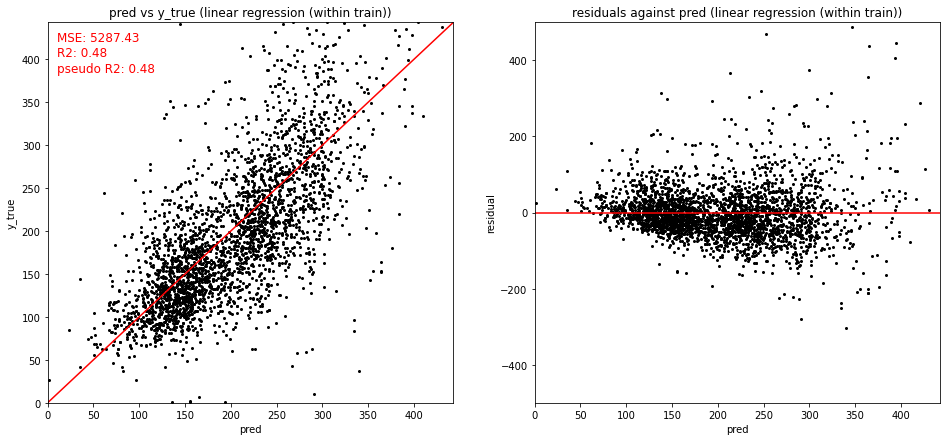

In [45]:
pred_eval(y_train_pred, y_train, "linear regression (within train)")

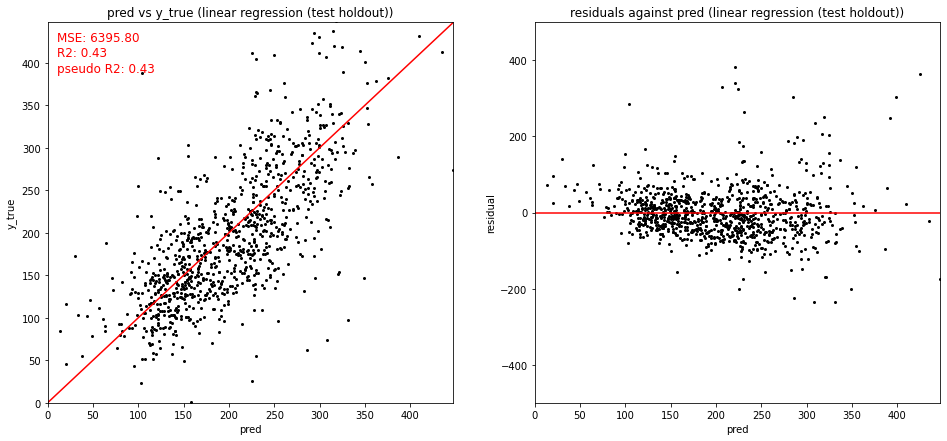

In [46]:
pred_eval(y_test_pred, y_test, "linear regression (test holdout)")

Some initial conclusions from examining the predictions and residuals:
- While there appears to be _slight_ over-prediction and low values and under-prediction at high values, the distribution of the residuals is fairly uniform around 0, indicating that a linear model is potentially a good choice (not biased)
- The explained variance (or coefficient of determination) is `0.48` in the train set and `0.40` in the holdout set, which while different is not so significant that I am overly worried about an overfit (or high variance) model
  - Answer to __Analysis 4__ (really Modeling 4)

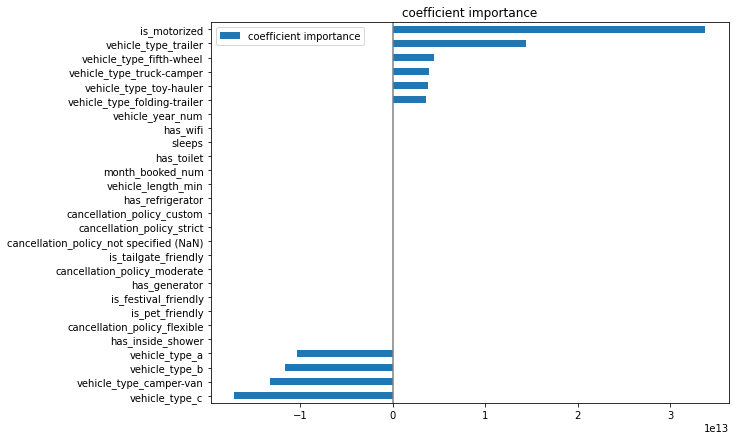

In [47]:
coefs_std = pd.DataFrame(
    pipe['linreg'].coef_ * X_train.std(axis=0),  # need to adjust by stdev of features to account for different scales
    columns=["coefficient importance"],
    index=X_train.columns,
).sort_values(by='coefficient importance')

coefs_std.plot(kind='barh', figsize=(12, 7))
plt.title('coefficient importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

When interpreting linear regression coefficients, it is important to remember that features are _conditioned on_ other features, so a high coefficient value is only in the presence of other regressors and holding all other values constant.  

With that caveat, we can see that being motorized is the single most important feature in this model for predicting average daily rental value.  You can see that the motorized classes (types A, B, C, and camper van) all make negative adjustments to this motorized feature, since it is so large.  Among the non-motorized classes, a trailer is the highest value predictor, followed by other non-motorized classes.

In general, it is surprising to see how little value size or capacity play a role in this model, as number of sleeps and length are not strong predictors (holding all else constant).  Also, amenities such as wifi, toilet, and inside shower are relatively unimportant as well (holding all else constant).  Perhaps there is a subset of RVs where these are differentiating factors, but that is not identifiable in the full sample.

Let us examine a different, non-linear, modeling choice for additional insights.

In [48]:
print(coefs_std.sort_values(by='coefficient importance', ascending=False))

                                         coefficient importance
is_motorized                                       3.379530e+13
vehicle_type_trailer                               1.445358e+13
vehicle_type_fifth-wheel                           4.439613e+12
vehicle_type_truck-camper                          3.906778e+12
vehicle_type_toy-hauler                            3.782065e+12
vehicle_type_folding-trailer                       3.563874e+12
vehicle_year_num                                   2.435715e+01
has_wifi                                           1.421612e+01
sleeps                                             1.326179e+01
has_toilet                                         1.295039e+01
month_booked_num                                   6.568761e+00
vehicle_length_min                                 6.076182e+00
has_refrigerator                                   4.880115e+00
cancellation_policy_custom                         1.665805e+00
cancellation_policy_strict              

In [49]:
# W = X.assign(booked_price_per_day_num=y)
# W.corr()['booked_price_per_day_num'].sort_values()

### xgboost

In [53]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor()  
xgb_reg.fit(X_train, y_train)
xgb_train_pred, xgb_test_pred = map(xgb_reg.predict, (X_train, X_test))

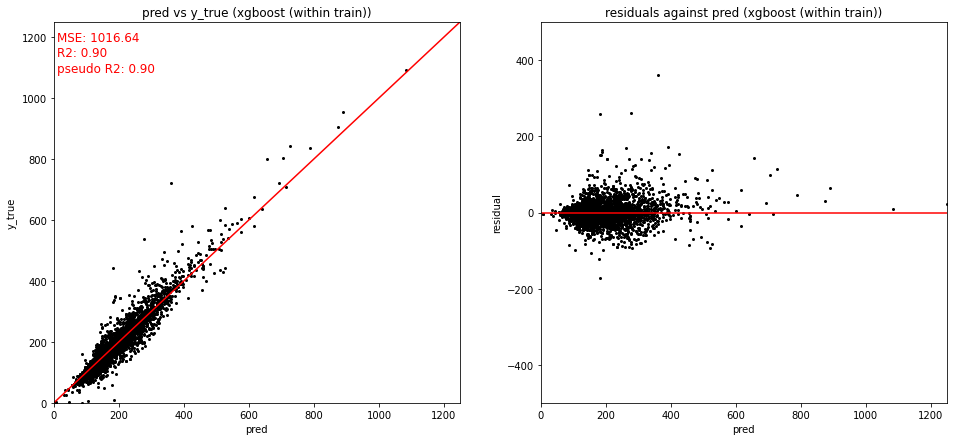

In [54]:
pred_eval(xgb_train_pred, y_train, "xgboost (within train)")

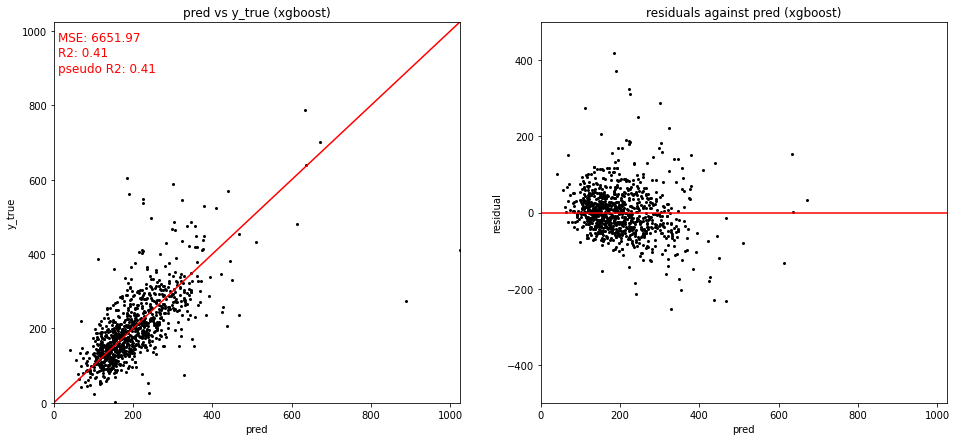

In [55]:
pred_eval(xgb_test_pred, y_test, "xgboost")

There is evidence here to conclude that the off-the-shelf XGBoost is overfitting the training data and adding unnecessary variance in the model.  With a pseudo R2 value of `0.90` in the train set and `0.41` in the holdout set, the model appears to be overfit.  

The similarity in R2 (linear assumption) and pseudo R2 (some non-linear correction) is also evidence that the relationship between the target and predictor variables is fairly linear.

Lastly, there appear to be some very high outlier predictions (above $800) that may be contributing to some of the high MSE and variance, so some robustness handling may be in order for future work.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

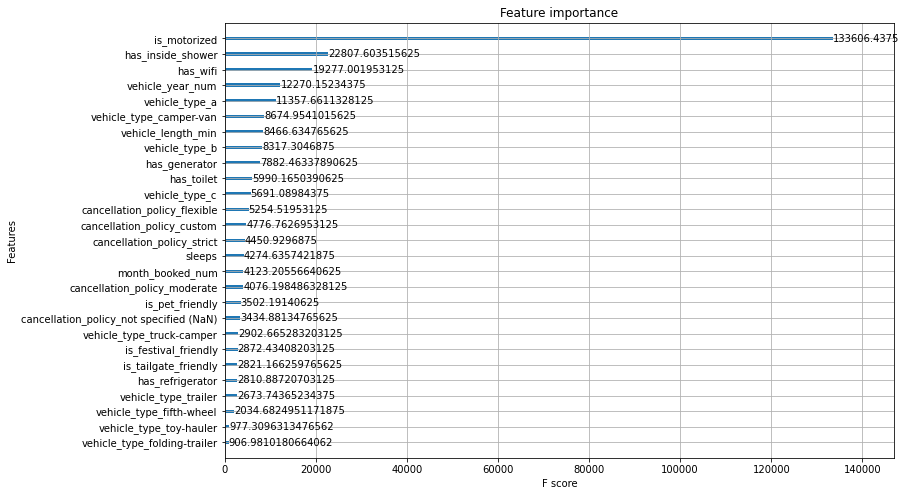

In [56]:
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.plotting
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(xgb_reg, importance_type="gain", ax=ax)

Interpreting random forest importances is different that linear regression coefficients.  For one, there needs to be no correction for scaling due to the splitting nature of decision trees.  Two, you cannot tell whether a feature is positively or negatively important, nor whether or how it interacts with other features.  This is a very high-level interpretation.

That being said, motorized status is again the most important predictor of average daily rental value.  Interestingly, some other amenities-related features are important in the xgboost model (although it's worth remembering that it is overfit).  Having these more "luxurious" features like inside shower, wifi, and generator contribute to the average value of the prediction.

Additionally, the age of the RV is more important here, as well as the length.  Friendliness features are not as important in this model, nor were they in the linear regression.

#### 2. Assume we want to categorize each listing into “luxurious”, “premium”, and “basic”. How would you go about building a model to classify the listings into each of these categories?  
    a. What would you propose are the main characteristics of a “luxurious” rental?
    b. How would you do feature engineering?
    c. How would you evaluate the model?

This is an interesting question, and it allows for several different approaches.  One approach would be to try to learn the important "luxurious" features by creating a variable that either represents luxurious rentals or is a proxy.  The second approach would be more of a bottom-up approach, where you would categorize your input features as to whether they reflected luxury, and then categorize your rentals using this taxonomy.

I am always a fan of deploying a fast and simple approach as a baseline, and then iterating from there ("best is the enemy of better").  However, we risk imposing our own biases when making a taxonomy, and I admit to being biased about using machine learning as an approach (being a machine learning scientist and all).  However, we should have good intuitions about what make a RV luxurious, both in order to evaluate the model and to understand how are travelers will interact with the classifications.

I don't think that price alone will be sufficient as a proxy for luxury, as it potentially reflects many other characteristics such as size, accomodation, motorized status, location, and others.  Rather, holding these "non-amenities" factors constant, we could learn which amenities contribute most to average daily price, and thus learn something about valuable amenities.  This is based on the assumption that luxurious == higher price, all else being constant.

Using a counterfactual-based model may be a good approach here.  In a counterfactual model, you first train a model to predict some outcome variable (in our case, booking value, or nigtly rate).  Then, in a second step, you make predictions for a holdout set to serve as your baseline.  The third step is to perturb your input variables in order to predict "what would be the value for this rental if evertything was the same except for feature x," and this observed delta across your prediction space allows you to draw conclusions about the value of that feature, holding all else constant.

In a way, it's an approach to drawing causal inference between your features and your target, although in reality it is not true causal inference (which requires careful experimental design), but a proxy.  Additionally, there is some complication regarding the interaction of features (perhaps a wifi connection is more important in certain markets, or in certain RV types) that would need consideration.

A good first step is start with individual features.  You could perturb all input features, but then you would again realize that motorized status and length are predictive of value.  Since this is an experiment (to determine what RVs are luxurious, premium, and basic), then it is useful to start with a hypothesis.  In this case, I would hypothesize that these features are indicative of luxury (and not inherent RV features):
- all amenities (wifi, shower, generator, kitchen amenities, toilet, etc.)
- age
- vehicle type
- vehicle make and model (would require extensive data cleaning)

These are factors I would hold constant (or not consider as luxury features):
- motorized status
- sleeps
- length
- friendliness (pet, festival)
- cancellation policy
- seasonality

Potential confounding or interaction terms worth exploring:
- location

Given the results of these counterfactuals, you would have a sense of which amenities are the most important to overall value (a proxy for luxury).  You could then classify (and even order) your features with respect to luxury, and classify rentals into three categories based on which (or how many amenities) they have.  No or few amenities would be "basic" (perhaps the lower 33%ile of rentals), a moderate amount would be "basic" (perhaps middle 33%ile), and then most equipped would be "luxurious."  You could consider defining markets and doing this percentiling distribution differently across markets or having your luxury class be more exclusive than 33%.

This gives you a classified data set.  

A good way to evaluate whether or not your classification is useful is to have a holdout set against which you validate your model.  Holding non-luxurious features constant, how well does your classification system do at predicting the value of a rental?  Again, this is all based on the assumption that luxury is more expensive, which requires knowledgeable owners pricing their rentals consistent with this assumption.

If your classification method does predict value in a holdout set, then you can conclude you have identified some features that are indicative of luxury and can consider the best way to implement your model on the platform.

### Assume we want to reach out to all the owners of “basic” listings to promote how they can upgrade their rental to get a higher return for their daily booking price.
    a. Outline a testing strategy to see how effective is your model
    b. How would you estimate the impact of this model?
    c. How can you further optimize your model to be more accurate?

Assuming that we have a model that reliably predicts "basic" listings, counterfactuals again may be a good choice, provided the features identified are changeable.  It is not appropriate to recommend that an owner "make their RV newer" or "add a motor", even though they have a causal relationship to booking price, because those are unchangeable features.  Working with customer support, sales and outreach teams, and even owners can be helpful in identifying changeable features.  Some initial ideas include wifi support, generator, and friendliness features.

But rather than use counterfactuals again, I would propose a different approach, one that is based on traveler's shopping behaviors.  This would require additional data not present in the provided dataset.  For a given user who ends up booking a rental, identify which other units they viewed in the session (or attributable sessions) preceding this booking.  This give a "competitive set" for the rental, and can identify similar properties.  Then, you can build a model for an individual rental using all of the competitive units, along with a booking classification target.  Building a model on this dataset will allow you to identify the most significant features that led to a property being booked.

This has the benefit of not requiring you to hold constant other "non-changeable" variables, on the assumption that you have biased your data set to only be of comparable properties by learning from the traveler's shopping behavior.  You will need to tune your model (what counts as a "view"? A click and a bounce?  Viewing for some amount of time?  Messaging the owner?), but it has the benefit of learning what rentals are similar based on your customers' behavior, not based on your own assumptions.  

Then you can make recommendations on what to change (based on your earlier research on changeable features), along with the rationale that "you lost out on bookings to your competitors for these (changeable) reasons", which is a strong competitive motivator.

One potential way to measure of the impact of this model is using a pre- and post-change observation.  For all properties (whether or not you made a recommendation), you can build a dataset of pre- and post-booking behavior for when they made a changeable amenity.  You can then compare the change in booking value per feature to your estimate of the value of that feature for a measure of the accuracy of your model.

With any pre- and post-treatment model, you make some strong assumptions and tradeoffs.  You assume that the value and conditions of the booking remain constant over time (definitely not true), but you gain the fact that your observation has only changed on the feature of interest.  With a long enough observation window, you can smooth out effects of seasonality by observing changes across different booking seasons.

As far as measuring the impact, the goal of the model is purely to encourage owners to make changes to their basic rentals.  To this end, you can measure adoption rates of the changes you recommend (with some cutoff time post-recommendation).  However, this couples your model with the messaging and rationale components, which are not necessarily in the control of the machine learning scientist (but are necessary components in the deployment of any machine learning product).

An additional feature that could potentially help this model is to score rentals in the competitive set on a "similarity" scale, and use such similarity weights when calculating the value of different changeable features.  In the above model, all units in the competitive set are treated identically with respect to the focal unit, but you can imagine a way to weight your outcome variable by some similarity score, such that observations of very similar units would be counted more than somewhat similar units.

This similarity score could be calculated using the cosine similarity of feature vectors, or through some other model that generates embedded representations of all units, or another approach.  This approach would, of course, need to be evaluated, since now you are imposing your assumptions on the data set - instead of relying purely on the travelers shopping comparisons, you are saying that as a modeler you need to impose more constraints.